<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Preprocess-10X" data-toc-modified-id="Preprocess-10X-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocess 10X</a></span></li><li><span><a href="#Load-10X" data-toc-modified-id="Load-10X-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load 10X</a></span></li><li><span><a href="#Single-Cell-Aggregate" data-toc-modified-id="Single-Cell-Aggregate-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Single Cell Aggregate</a></span></li><li><span><a href="#To-AnnData" data-toc-modified-id="To-AnnData-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>To AnnData</a></span></li></ul></li><li><span><a href="#Main" data-toc-modified-id="Main-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Main</a></span><ul class="toc-item"><li><span><a href="#Obtain-UMAP-data" data-toc-modified-id="Obtain-UMAP-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Obtain UMAP data</a></span></li><li><span><a href="#Calculate-kmeans-clusters" data-toc-modified-id="Calculate-kmeans-clusters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Calculate kmeans clusters</a></span></li><li><span><a href="#Plot-clusters" data-toc-modified-id="Plot-clusters-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Plot clusters</a></span></li><li><span><a href="#Pseudotime" data-toc-modified-id="Pseudotime-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Pseudotime</a></span><ul class="toc-item"><li><span><a href="#Initialisation" data-toc-modified-id="Initialisation-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Initialisation</a></span></li><li><span><a href="#Creating-clusters-from-normalized-data" data-toc-modified-id="Creating-clusters-from-normalized-data-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Creating clusters from normalized data</a></span></li></ul></li></ul></li></ul></div>

# Import

In [1]:
# !pip install phate scprep umap-learn tasklogger magic-impute louvain seaborn scanpy fa2
# !pip install git+https://github.com/jacoblevine/phenograph.git
# !pip install jupyter_contrib_nbextensions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
%matplotlib inline

import sklearn
import sklearn.cluster
import sklearn.manifold

import scprep
import os
import tasklogger
import phate
import umap

import graphtools as gt
import magic
import phenograph
import louvain

from sklearn.decomposition import PCA

# Functions

## Preprocess 10X

In [3]:
def preprocess_10X(data, name='10X-project', percent_mt=20, max_features=5000, min_features=200):
    """This function takes a data-frame (genes x cells), 
    creates a Scprep object with it and filters the object for default tags such as  
    Min and max nFeature_RNA and % of MT

    Parameters:
    @param data data-frame
    @param percent_mt integer [0-100]
    @param max_features integer [0-Inf]
    @param min_features integer [0-Inf]
    
    Returns:
    @return Preprocessed Dataframe
    """
    #Remove empty cells and empty genes
    data = scprep.filter.filter_empty_cells(data)
    data = scprep.filter.filter_empty_genes(data)
    
    #Remove elements based on mythocondrial percentage
    mt_genes = scprep.select.get_gene_set(data, starts_with=["MT-", "mt-"])
    data = scprep.filter.filter_gene_set_expression(data=data, genes=mt_genes, percentile=100-percent_mt, keep_cells='below')
    
    #Remove elements based on number of cell and number of features
    data = scprep.filter.filter_library_size(data=data, cutoff=(min_features, max_features), keep_cells='between')
    data = scprep.filter.filter_rare_genes(data=data, cutoff=0, min_cells=3)

    return data

## Load 10X

In [4]:
def load_10X(dir_path, name='10X-project',percent_mt=20, max_features=5000, min_features=200):
    """This function takes the path to a 10X output folder and instanciates the Scprep object
    
    Parameters:
    @param file string (path to file)
    @param percent_mt integer [0-100]
    @param max_features integer [0-Inf]
    @param min_features integer [0-Inf]
    
    Returns:
    @return Preprocessed DataFrame
    """
    data = scprep.io.load_10X(dir_path, sparse=True, gene_labels='both')
    return preprocess_10X(data=data, percent_mt=percent_mt, max_features=max_features, min_features=min_features)

## Single Cell Aggregate

In [5]:
def sc_aggregate(metadata, cluster_param, target_param, order_by, value_weight=0.5, pop_weight=0.5):
    """ Aggregate clusters of celltypes and extract proportion of a group
     
     
    @param metadata Target metadata dataframe
    @param cluster_param Str parameter identifying clusters
    @param target_param Str Name of the metadata feature to aggregate
    @param order_by List name of the metadata feature to order by
    @return DataFrame with different_columns of percentages
    @return Plot of percentages
    """
    keys = metadata[target_param].value_counts().keys()
    #Get percentage of population per param in metadata
    pop_perc = metadata[target_param].value_counts()/metadata[target_param].value_counts().sum() *100

    perc_keys = [x+'_perc' for x in keys]
    df=pd.DataFrame(columns=perc_keys)
    
#     df['tot_value'] = 0

    for c in sorted(metadata[cluster_param].unique()):
        #Get subset cluster data
        subset = metadata[metadata[cluster_param]==c]
        
        #Get total values 
        subset_val=subset[target_param].value_counts().to_dict()

        tot_value = subset[target_param].value_counts().sum()

        [subset_val.setdefault(k, 0) for k in keys]
        return_values = [subset_val[p]/tot_value*100 for p in subset_val]
        
        #Apply population percentage with appropriate weight
        return_values = np.array(return_values)*value_weight + np.array(pop_perc) * pop_weight 

        df.loc[c] = [round(r,2) for r in return_values]
      
    if isinstance(order_by, list):
        df = df.sort_values(by=[o+'_perc' for o in order_by], ascending=False)
    else:
        df = df.sort_values(by=order_by+'_perc', ascending=False)
        
    axis = df[[x+'_perc' for x in keys]].plot(kind="bar", stacked=True)
#     fig = axis.get_fig ure()
    
    return df, axis

## To AnnData

In [6]:
def df_to_AnnData(data, metadata, save_file_name):
    """ Function takes our current data and metadata and outputs an AnnData object that we can use to execute pseudotime
    
    Parameters:
    @param data DataFrame - our current data (already preprocessed)
    @param metadata DataFrame - our current metadata
    @param save_file_name Str - name for the h5ad save file
    
    Returns:
    @return adata AnnData - our AnnData object
    """
    
    sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
    sc.logging.print_versions()
    results_file = './write/{}.h5ad'.format(save_file_name)
    sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures
    
    adata = sc.AnnData(data)
    for c_name, c_data in metadata.iteritems():
        adata.obs[c_name] = c_data
        
    return adata

# Main

In [7]:
data = scprep.io.load_csv("../data/moein_data/moein.data.csv", cell_axis = "column")
metadata = scprep.io.load_csv("../data/moein_data/moein.meta_data.csv")

C:\Users\sburw\anaconda3\lib\site-packages\scprep\sanitize.py:51: RuntimeWarning: Data is not numeric. Many scprep functions will not work.
  warnings.warn(


In [8]:
data_phate = phate.PHATE().fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 13592 observations and 3897 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 8.34 seconds.
    Calculating KNN search...
    Calculated KNN search in 82.96 seconds.
    Calculating affinities...
    Calculated affinities in 64.57 seconds.
  Calculated graph and diffusion operator in 156.64 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 11.05 seconds.
    Calculating KMeans...
    Calculated KMeans in 44.00 seconds.
  Calculated landmark operator in 59.23 seconds.
  Calculating optimal t...
    Automatically selected t = 6
  Calculated optimal t in 4.70 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.15 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 16.80 seconds.
Calculated PHATE in 238.57 seconds.


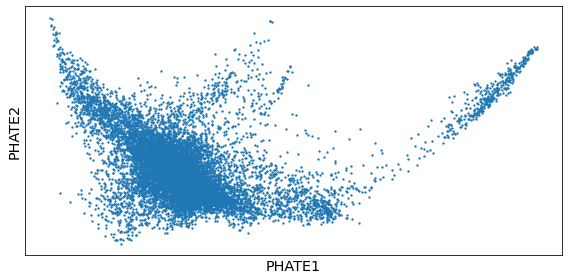

In [9]:
scprep.plot.scatter2d(data_phate, figsize=(8,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

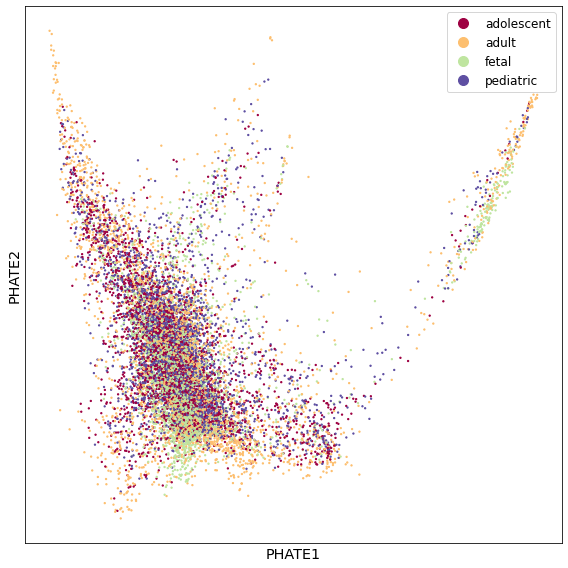

In [10]:
scprep.plot.scatter2d(data_phate, c=metadata["age"],figsize=(8,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

## Obtain UMAP data

In [11]:
#Obtain UMAP data
with tasklogger.log_task("UMAP"):
    data_umap = umap.UMAP(n_components=60).fit_transform(data)
    data_umap = pd.DataFrame(data_umap, index=data.index)

Calculating UMAP...
Calculated UMAP in 99.47 seconds.


## Calculate kmeans clusters

In [12]:
kmeans_clusters = sklearn.cluster.KMeans().fit_predict(data_umap)

## Plot clusters

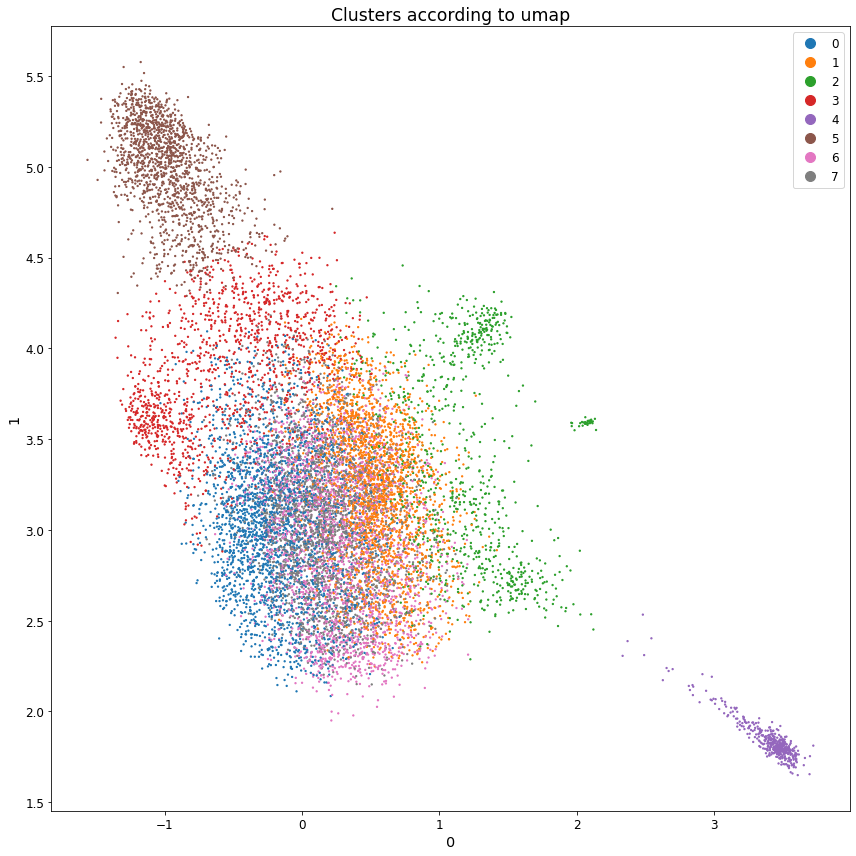

In [13]:
# scprep.plot.scatter2d(data_umap, c=metadata['age'],figsize=(12, 12),  title="Clusters according to umap")
scprep.plot.scatter2d(data_umap, c=kmeans_clusters,figsize=(12, 12),  title="Clusters according to umap")

In [14]:
metadata

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.6,seurat_clusters,age,S.Score,G2M.Score,Phase,integrated_snn_res.0.4
TCGCGAGGTTTAGGAA_1,HP773,1034.000000,650,3.288201,3.0,5,pediatric,-0.023260,-0.018602,G1,5
ACCTTTATCGTGACAT_1,HP773,2673.000000,1391,3.179948,4.0,0,pediatric,-0.051620,0.117481,G2M,0
CGGAGCTTCCGCATCT_1,HP773,927.000000,610,1.402373,3.0,0,pediatric,-0.037142,-0.079287,G1,0
CGCTGGAGTCGTTGTA_1,HP773,1820.000000,1034,3.241758,3.0,0,pediatric,0.005744,0.011691,G2M,0
GTGTGCGAGCGGCTTC_1,HP773,617.000000,365,3.727715,2.0,6,pediatric,-0.009725,-0.019488,G1,6
...,...,...,...,...,...,...,...,...,...,...,...
CTGCCTACAAGCTGAG_12,HF588,804.302460,337,1.001472,0.0,2,fetal,0.105172,-0.052438,S,2
TCGCGAGGTTGCTCCT_12,HF588,772.912931,310,1.519034,0.0,2,fetal,-0.004290,-0.050681,G1,2
AGAGCTTTCACCCGAG_12,HF588,930.952502,446,1.893067,2.0,0,fetal,-0.032441,-0.032703,G1,0
CTCGAAAAGATCGGGT_12,HF588,882.212233,393,2.471061,1.0,2,fetal,-0.018380,0.063663,G2M,2


,pediatric_perc,adolescent_perc,fetal_perc,adult_perc
1,31.42,26.96,25.44,16.18
3,29.61,27.79,24.80,17.80
5,28.71,26.98,24.44,19.86
0,28.86,27.74,22.76,20.64
4,34.61,27.14,22.25,16.00
6,34.27,29.78,20.55,15.39
8,38.21,23.01,19.46,19.31
2,57.95,15.15,13.66,13.25


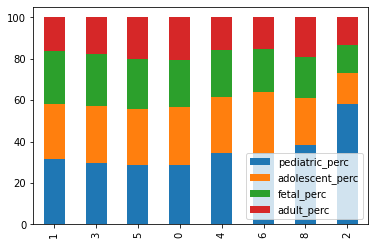

In [15]:
df, axis = sc_aggregate(metadata=metadata, 
                        cluster_param ='seurat_clusters', 
                        target_param = 'age', 
                        order_by = ['fetal'])

df

## Pseudotime

### Initialisation

In [16]:
adata = df_to_AnnData(data,metadata,'moein_AnnData')

-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 7.2.0
anndata             0.7.4
backcall            0.2.0
bottleneck          1.3.2
cffi                1.14.0
cloudpickle         1.5.0
colorama            0.4.3
cycler              0.10.0
cython_runtime      NA
cytoolz             0.10.1
dask                2.20.0
dateutil            2.8.1
decorator           4.4.2
deprecated          1.2.10
future              0.18.2
get_version         2.1
graphtools          1.5.2
h5py                2.10.0
igraph              0.8.2
ipykernel           5.3.2
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.17.1
joblib              0.16.0
kiwisolver          1.2.0
legacy_api_wrap     1.2
llvmlite            0.33.0+1.g022ab0f
louvain             0.7.0
magic               2.0.3
matplotlib          3.2.2
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.0.1
nt                  NA
ntsecuritycon       NA
numba              

### Creating clusters from normalized data

In [17]:
# sc.pp.neighbors(adata, n_neighbors=4, n_pcs=40)
# sc.tl.umap(adata)
# # sc.tl.umap(adata)
adata.X


array([[ 7.2969407e-01,  8.3160490e-02,  3.1170840e+00, ...,
         1.0826419e-01,  1.4820486e-02, -4.4212332e-03],
       [ 1.1840255e+00,  4.4632566e-01,  3.7552016e+00, ...,
        -2.2291066e-02, -4.4276278e-02, -3.1444803e-02],
       [ 8.9540344e-01,  5.3866768e-01,  2.0070713e+00, ...,
        -7.4491613e-02,  1.3618467e-03,  1.9028723e-02],
       ...,
       [ 1.0301383e+00,  9.3476996e-02,  4.3008571e+00, ...,
         8.5167527e-02, -3.4910321e-02,  4.8499396e-03],
       [ 1.7669013e+00,  5.5993557e-01,  3.2142141e+00, ...,
        -1.2958236e-01,  1.5419278e-03, -3.3154339e-01],
       [ 1.9655396e+00,  3.2158196e+00,  4.6964049e+00, ...,
         1.5198702e-01,  3.8000207e-02,  1.7388171e-01]], dtype=float32)

In [18]:
sc.pl.umap(adata, color=['CST3'])

... storing 'orig.ident' as categorical
... storing 'age' as categorical
... storing 'Phase' as categorical


KeyError: "Could not find entry in `obsm` for 'umap'.\nAvailable keys are: []."

In [ ]:
sc.tl.rank_genes_groups(adata, ' method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

In [ ]:
# adata.obs['seurat_clusters'] = metadata['seurat_clusters']
# adata.obs['age']= metadata['age']
# sc.pl.draw_graph(adata, color='age', legend_loc='on data')
adata

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

In [ ]:
sc.pl.draw_graph(adata, color='seurat_clusters', legend_loc='on data')

In [ ]:
sc.tl.louvain(adata, resolution=1.0)

In [ ]:
sc.tl.paga(adata, groups='louvain')

In [ ]:
sc.pl.paga(adata, color=['louvain'])

In [ ]:
sc.tl.rank_genes_groups(adata, 'age', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)